# Prototype Model
---

* Regression
* 2009 data로 class1,2,3 10fold


https://docs.google.com/presentation/d/1cI3teBcQoGBhfrdVrv9rnM4jHGaPToDS7Zh7t0q7GKg/edit#slide=id.g97e66187c6_0_6

In [25]:
import os

os.sys.path.append(r'/docker_mnt/data5/jin/jin/python/')

os.sys.path

['/docker_mnt/data4/sgcwhb/Malocclusion/regression',
 '/docker_mnt/data4/sgcwhb/Malocclusion/regression',
 '/docker_mnt/jin/jin/python',
 '/root/miniconda3/lib/python37.zip',
 '/root/miniconda3/lib/python3.7',
 '/root/miniconda3/lib/python3.7/lib-dynload',
 '',
 '/root/miniconda3/lib/python3.7/site-packages',
 '/root/miniconda3/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython',
 '/docker_mnt/data5/jin/jin/python/',
 '/docker_mnt/data5/jin/jin/python/']

In [26]:
import tensorflow as tf

In [27]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12848704056208378138,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6134937699783498592
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10995721831
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16813595406165745329
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14906952861079568277
 physical_device_desc: "device: XLA_GPU device"]

In [28]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

import glob
import os
import pprint
from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

# Data Science
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

env: PYTHONHASHSEED=0


## Paths
---

In [29]:
so_type = 'so_rl'

input_path_root = r'../data/input_data/'

# <model 저장>
# output_path_root = r'../results/'
output_path_root = r'../results/hyg/'
output_path = os.path.join(output_path_root, r'data_prediction/', so_type)
# output_path_weight = os.path.join(output_path, r'weights/')

# try:
#     os.makedirs(output_path_weight)
# except FileExistsError as err: 
#     print(err)
# else:
#     print(output_path)
#     print(output_path_weight)

In [30]:
input_path_root

'../data/input_data/'

In [31]:
output_path_root

'../results/hyg/'

## Data
---
- Class 0 : 분별하기 어려운 data (65 sample) -> 제외

- Class 3 : 하악이 상악보다 앞으로 돌출된 경우 (1136 sample) -> -1.0
- Class 1 : 상하악의 맞물림 상태는 정상이지만 치열이 고르지 않은 경우 (1707 sample) -> 0.0
- Class 2 : 상악이 하악보다 앞으로 돌출된 경우 (1175 sample) -> 1.0


In [32]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0
    label_df.loc[label_r == 2, 'angle_class_r'] = 1
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

def generate_data_by_patient(x, y):
    if x.shape[-1] == 12:
        x = np.concatenate([x[..., :3], x[..., 3:6], x[..., 6:9], x[..., 9:]]) 
        y = np.concatenate([y[:, 0], y[:, 1], y[:, 2], y[:, 3]])
    elif x.shape[-1] == 6:
        x = np.concatenate([x[..., :3], x[..., 3:]]) # Right side,Left side !!!
        y = np.concatenate([y[:, 0], y[:, 1]])
    
    return x, y

# def generate_info_df_by_patient(info_df):
#     info_df_r = info_df.copy()
#     for row_idx, info in enumerate(info_df_r['info']):
#         info_df_r.iloc[row_idx] = info + '_r'
        
#     info_df_l = info_df.copy()
#     for row_idx, info in enumerate(info_df_l['info']):
#         info_df_l.iloc[row_idx] = info + '_l'
    
#     info_df = pd.concat((info_df_r, info_df_l), ignore_index=True)
#     del info_df_r, info_df_l
    
#     info_df1 = info_df.copy()
        
#     info_df2 = info_df.copy()
#     for row_idx, info in enumerate(info_df2['info']):
#         info_df2.iloc[row_idx] = info.replace('01A1', '02B1')
    
#     info_df = pd.concat((info_df1, info_df2), ignore_index=True)
#     del info_df1, info_df2

#     return info_df

In [33]:
x = np.load(os.path.join(input_path_root, f'data_KNU_Diorco_so_imgs.npy'))
label_df = pd.read_csv(os.path.join(input_path_root, f'data_Diorco_label.csv'))
label_df = convert_label_class2reg(label_df)

y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()

x = x.astype(np.float32)
y = y.astype(np.float32)

x = x / 127.5
x = x - 1.

#x = np.concatenate((x[::2, ...], x[1::2, ...]), axis=3)
#y = np.concatenate((y[::2, ...], y[1::2, ...]), axis=1)

float32 (2009, 480, 784, 6)
float32 (2009, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     2009 non-null   object 
 1   tx_phase       2009 non-null   object 
 2   angle_class_r  2009 non-null   int64  
 3   angle_class_l  2009 non-null   int64  
 4   distance(r)    2009 non-null   float64
 5   distance(l)    2009 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 94.3+ KB


None

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
1,QH0026,Post-Tx,0,1,1.22,2.10
2,QH0041,Pre-Tx,1,0,2.57,0.88
3,QH0041,Post-Tx,1,0,3.58,1.05
4,QH0044,Pre-Tx,1,1,6.94,4.63
...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83
2006,QH1072,Post-Tx,1,1,7.41,5.26
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55


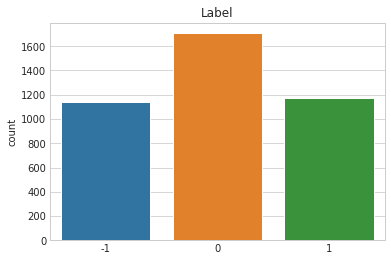

In [34]:
print(x.dtype, x.shape)
print(y.dtype, y.shape)
print()
display.display(label_df.info())
display.display(label_df)

plt.style.use('seaborn-whitegrid')
plt.figure()

plt.title('Label')
sns.countplot(np.concatenate([label_df.angle_class_r, label_df.angle_class_l]))

plt.show()
plt.style.use('seaborn-white')

In [35]:
cnt = np.concatenate([label_df.angle_class_r, label_df.angle_class_l])
cnt.shape

(4018,)

In [36]:
len(cnt[cnt==-1])

1136

In [37]:
len(cnt[cnt==0])

1707

In [38]:
len(cnt[cnt==1])

1175

In [39]:
len(cnt[cnt==-1]) + len(cnt[cnt==0]) + len(cnt[cnt==1])

4018

## Model
---

In [40]:
def build_model():
    base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(None, None, 3))

#     base_model.trainable = False

#     for layer in base_model.layers:
#         layer.trainable = False

    # base_model.summary()

    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(256, activation='relu', name='dense')(x)
    x = layers.Dropout(0.2, name='dropout')(x)
    output_main = layers.Dense(1, name='output_main')(x)

    model = models.Model(inputs=base_model.input, outputs=output_main)
    
    return model

## Train the Model
---

In [41]:
output_path = r'../results/prototype_regression_so_img/so_rl/'

## Evaluation
---

In [42]:
info_df = label_df.copy()
info_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
1,QH0026,Post-Tx,0,1,1.22,2.10
2,QH0041,Pre-Tx,1,0,2.57,0.88
3,QH0041,Post-Tx,1,0,3.58,1.05
4,QH0044,Pre-Tx,1,1,6.94,4.63
...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83
2006,QH1072,Post-Tx,1,1,7.41,5.26
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55


In [43]:
info_df.iloc[[0,3,5,6,7]]

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
3,QH0041,Post-Tx,1,0,3.58,1.05
5,QH0044,Post-Tx,1,1,9.15,7.06
6,QH0059,Pre-Tx,0,0,1.13,0.81
7,QH0059,Post-Tx,1,-1,1.53,0.49


K-Fold CV: 01/10


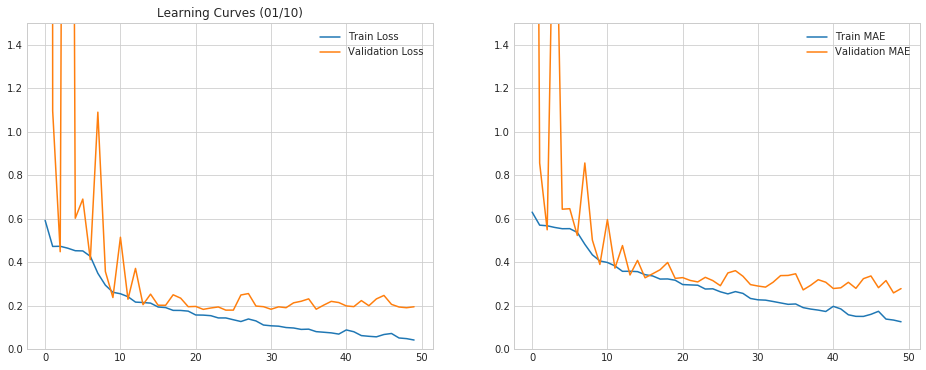

Min. validation loss epoch: 25
Min. validation MAE epoch: 49
K-Fold CV: 02/10


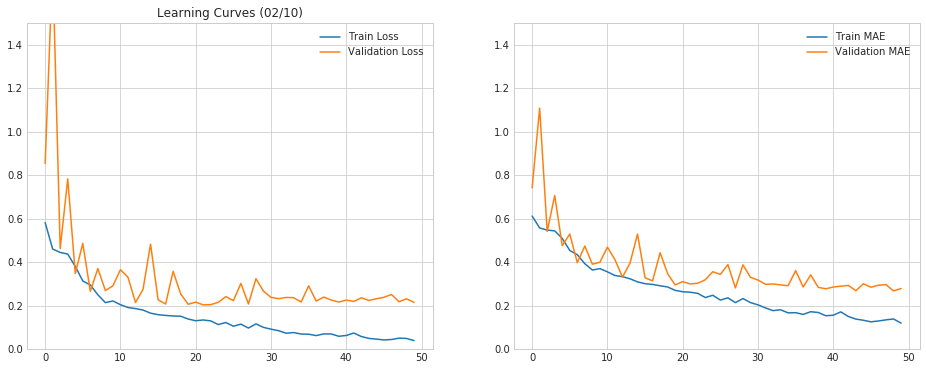

Min. validation loss epoch: 22
Min. validation MAE epoch: 49
K-Fold CV: 03/10


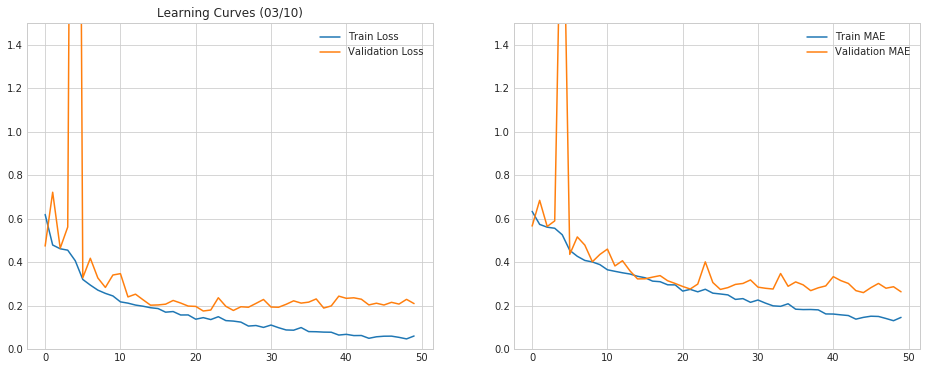

Min. validation loss epoch: 22
Min. validation MAE epoch: 45
K-Fold CV: 04/10


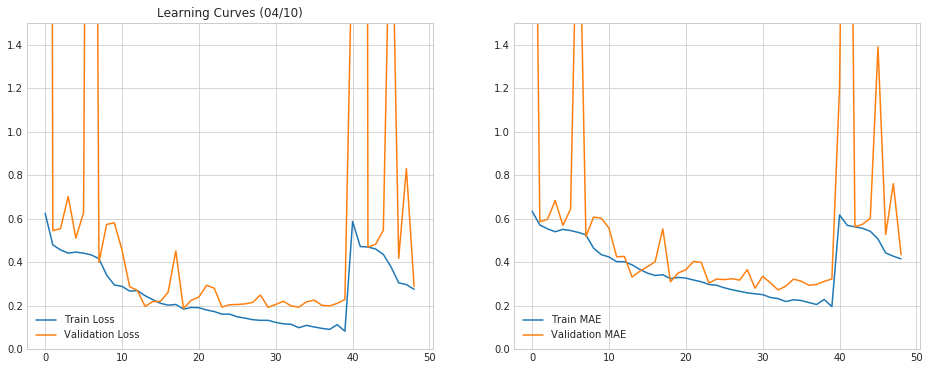

Min. validation loss epoch: 19
Min. validation MAE epoch: 33
K-Fold CV: 05/10


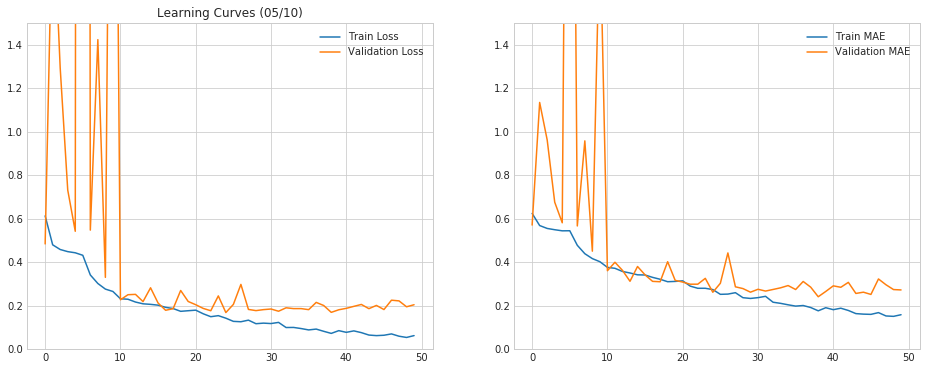

Min. validation loss epoch: 25
Min. validation MAE epoch: 39
K-Fold CV: 06/10


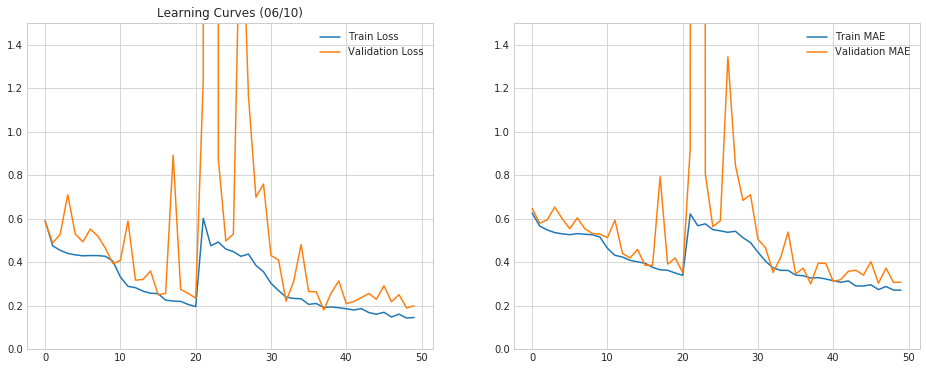

Min. validation loss epoch: 38
Min. validation MAE epoch: 38
K-Fold CV: 07/10


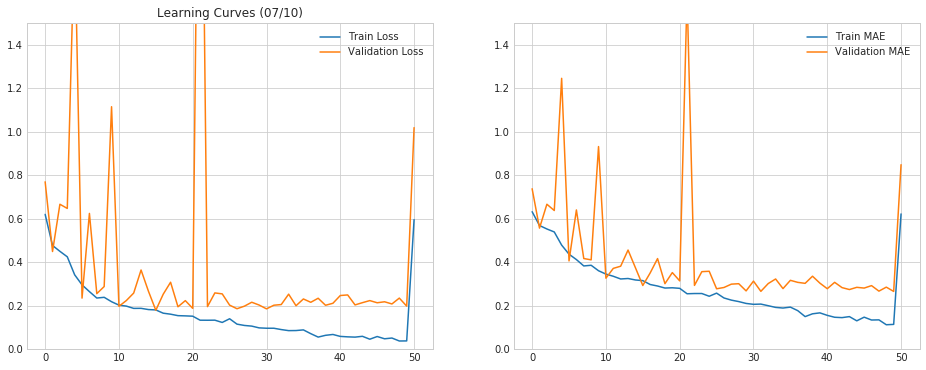

Min. validation loss epoch: 16
Min. validation MAE epoch: 50
K-Fold CV: 08/10


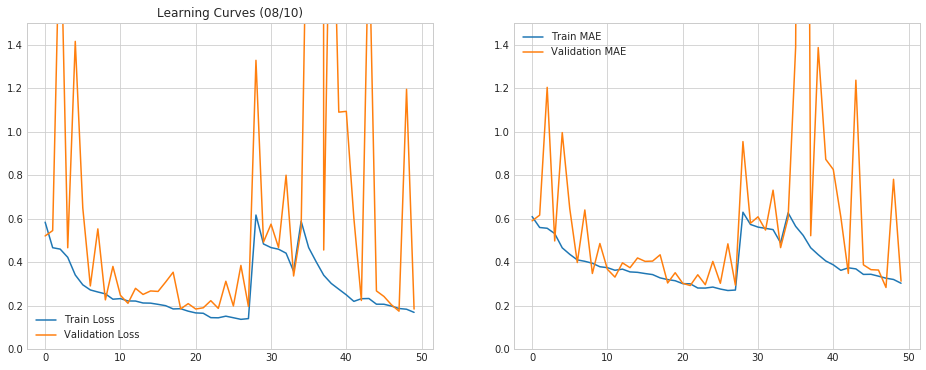

Min. validation loss epoch: 48
Min. validation MAE epoch: 48
K-Fold CV: 09/10


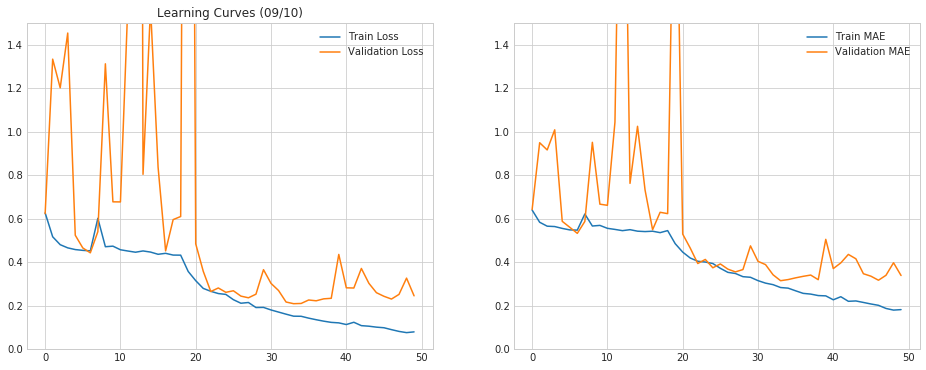

Min. validation loss epoch: 34
Min. validation MAE epoch: 34
K-Fold CV: 10/10


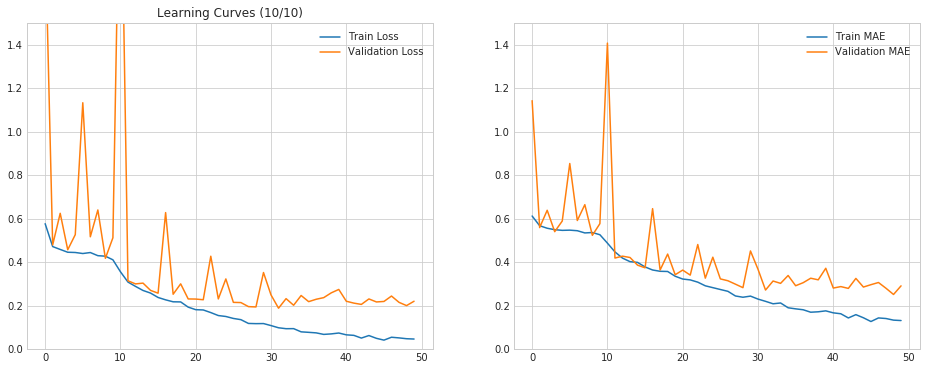

Min. validation loss epoch: 32
Min. validation MAE epoch: 49


In [44]:
metrics = []
predictions_kfold = []
labels_kfold = []
distance_regression = [] 

total_info =[]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')
    
    # 1. Data
    # ----------------------------------------
    
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    label_df_test = label_df.iloc[test_idxs]
    
    x_test, y_test = generate_data_by_patient(x_test, y_test)

    # 2. Paths
    # ----------------------------------------
    
    output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
    output_path_weight = os.path.join(output_path_kfold, r'weights/')

    # 3. Plot Learning Curves.
    # ----------------------------------------
    
    # log 저장: loss, mae, val_loss, val_mae
    log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))
    
    
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(16, 6))
    
    plt.subplot(121)
    plt.title(f'Learning Curves ({kfold_idx + 1:02d}/{kfold.n_splits:02d})')
    plt.plot(log_df.loss)
    plt.plot(log_df.val_loss)
    plt.ylim(0, 1.5)
    plt.legend(('Train Loss', 'Validation Loss'))
    
    plt.subplot(122)
    plt.plot(log_df.mae)
    plt.plot(log_df.val_mae)
    plt.ylim(0, 1.5)
    plt.legend(('Train MAE', 'Validation MAE'))
    
    plt.show()
    plt.style.use('seaborn-white')
    print(f'Min. validation loss epoch: {log_df.val_loss.idxmin() + 1}')
    print(f'Min. validation MAE epoch: {log_df.val_mae.idxmin() + 1}')
    
    
    
    info_df = label_df.copy()
    
    result_info_df = info_df.iloc[test_idxs]
    
    inference_df = result_info_df.copy()
    
    # 4. Load a Model.
    # ----------------------------------------
    
    K.clear_session()
    
    #sgcwhb/Malocclusion/results/prototype_regression_so_img/so_rl/model.hdf5
    model = models.load_model(os.path.join(output_path, r'model.hdf5'))
    #validation mae가 가장 적은 model weight load
    model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_mae.idxmin() + 1:08d}*.hdf5'))[0])
    
    # 5. Display
    # ----------------------------------------

    
    prediction = model.predict(x_test)
    
    prediction_distance_r = prediction[:int(prediction.shape[0]/2),0] #Right
    prediction_distance_l = prediction[int(prediction.shape[0]/2):,0] #left
    
    r = prediction_distance_r.copy()
    l = prediction_distance_l.copy()
    
    #-1~1사이 score
    r = np.round(r) #반올림
    r[r<-1]= -1
    r[r>1] = 1
    
    
    l = np.round(l)
    l[l<-1]= -1
    l[l>1] = 1    

#     print(l.shape)
#     print(r.shape)
#     print(info_df.shape)
#     print(result_info_df.shape)
    
    inference_df['prediction_class_r'] = r
    inference_df['prediction_class_l'] =l
    inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
    inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)



    
    inference_df.to_csv(os.path.join(output_path_kfold, r'info.csv'))
    total_info.append(inference_df)
    
total_df = pd.concat(total_info)
total_df.to_csv('../results/prototype_regression_so_img/so_rl/total.csv')


In [45]:
total_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),prediction_class_r,prediction_class_l,regression_distance_r,regression_distance_l
4,QH0044,Pre-Tx,1,1,6.94,4.63,1.0,1.0,1.062,0.980
6,QH0059,Pre-Tx,0,0,1.13,0.81,-0.0,-0.0,-0.039,-0.007
28,QH0126,Pre-Tx,1,1,3.07,1.82,1.0,0.0,0.801,0.222
31,QH0129,Post-Tx,0,-1,0.44,0.88,-1.0,-1.0,-0.894,-0.612
33,QH0145,Post-Tx,-1,-1,-1.54,-1.93,-1.0,-1.0,-0.787,-0.873
...,...,...,...,...,...,...,...,...,...,...
1937,QH0440,Pre-Tx,0,0,1.30,-0.04,-0.0,0.0,-0.024,0.006
1960,QH0542,Pre-Tx,-1,-1,-11.05,-11.91,-0.0,-1.0,-0.391,-1.032
1967,QH0556,Post-Tx,0,0,-0.27,-0.60,-0.0,-1.0,-0.013,-0.782
1986,QH0884,Pre-Tx,-1,-1,-1.92,-4.50,-1.0,-1.0,-0.952,-0.954


In [46]:
data = total_df['angle_class_r'].append(total_df['angle_class_l'])
prediction =  total_df['prediction_class_r'].append(total_df['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)


cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

[[ 796  311   29]
 [ 128 1437  142]
 [  11  225  939]]

Accuracy: 0.789


In [47]:
np.sum(cm)

4018

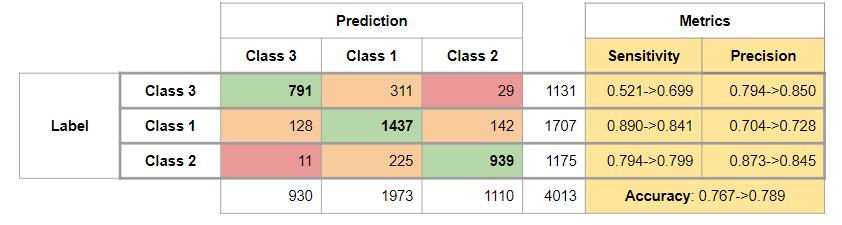